<a href="https://colab.research.google.com/github/JYJJEON/AIFFEL_Online_Quest/blob/main/Exploration/Exploration1/Exploration1rev3(test_accuracy_97.82%25).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

warnings.filterwarnings('ignore')

In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/tf_flowers/',
    download=True,
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tf_flowers/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
print(raw_train)
print(raw_validation)
print(raw_test)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


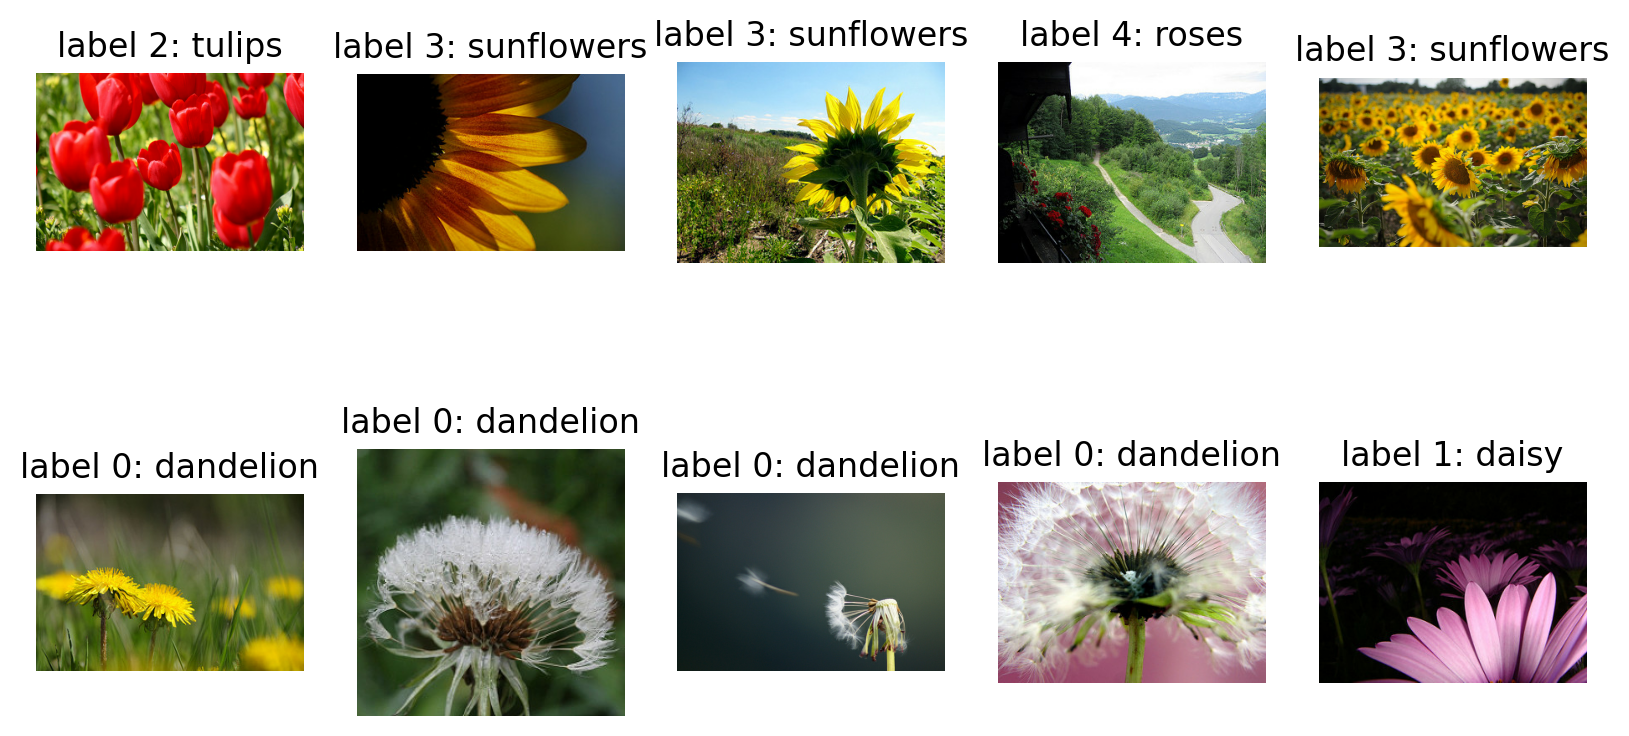

In [4]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [16]:
IMG_SIZE = 224 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/255.0) # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [17]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


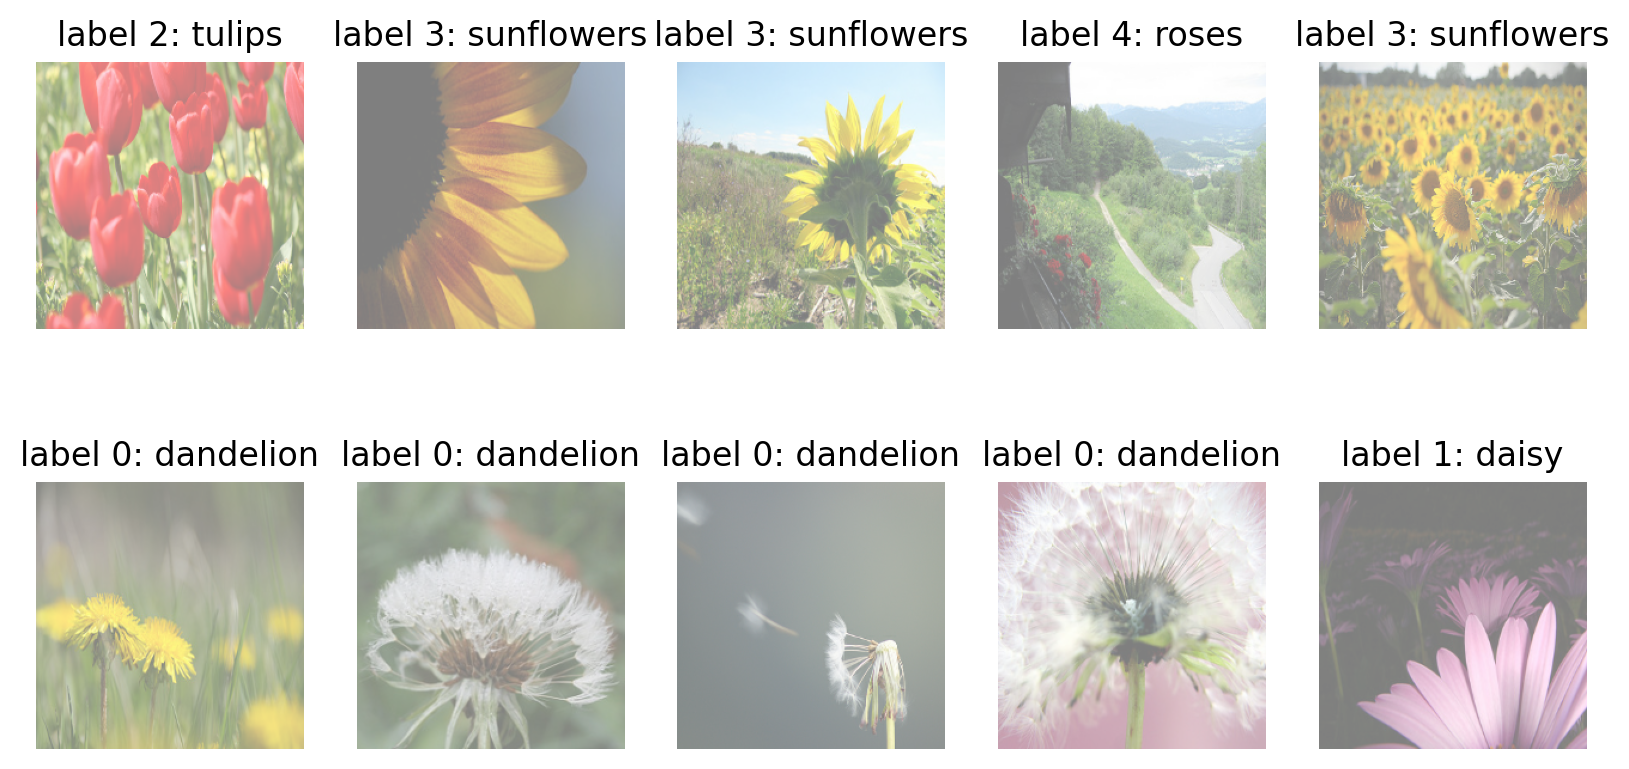

In [18]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [19]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [20]:
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32]))

In [21]:
!pip install --quiet vit-keras
!pip install tensorflow-addons
!pip install --quiet opencv-python
import tensorflow_addons as tfa
from vit_keras import vit

In [22]:
vit_model = vit.vit_b32(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

In [23]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(5, 'softmax')
    ],
    name = 'vision_transformer')

In [24]:
model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 11)                8459      
                                                                 
 batch_normalization_3 (Bat  (None, 11)                44        
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 5)          

In [29]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer,
              loss="sparse_categorical_crossentropy",
              metrics = ['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]



In [30]:
EPOCHS = 45
history = model.fit(train_batches,
                    validation_data = validation_batches,
                    epochs = EPOCHS,
                    callbacks = callbacks)

Epoch 1/45
92/92 [==============================] - ETA: 0s - loss: 1.2967 - accuracy: 0.5184
Epoch 1: val_accuracy improved from -inf to 0.82289, saving model to ./model.hdf5
92/92 [==============================] - 72s 429ms/step - loss: 1.2967 - accuracy: 0.5184 - val_loss: 0.5796 - val_accuracy: 0.8229 - lr: 1.0000e-04
Epoch 2/45
92/92 [==============================] - ETA: 0s - loss: 0.4774 - accuracy: 0.8747
Epoch 2: val_accuracy improved from 0.82289 to 0.92371, saving model to ./model.hdf5
92/92 [==============================] - 37s 404ms/step - loss: 0.4774 - accuracy: 0.8747 - val_loss: 0.2933 - val_accuracy: 0.9237 - lr: 1.0000e-04
Epoch 3/45
92/92 [==============================] - ETA: 0s - loss: 0.3028 - accuracy: 0.9431
Epoch 3: val_accuracy improved from 0.92371 to 0.95368, saving model to ./model.hdf5
92/92 [==============================] - 37s 404ms/step - loss: 0.3028 - accuracy: 0.9431 - val_loss: 0.2231 - val_accuracy: 0.9537 - lr: 1.0000e-04
Epoch 4/45
92/92 [=

TypeError: ignored

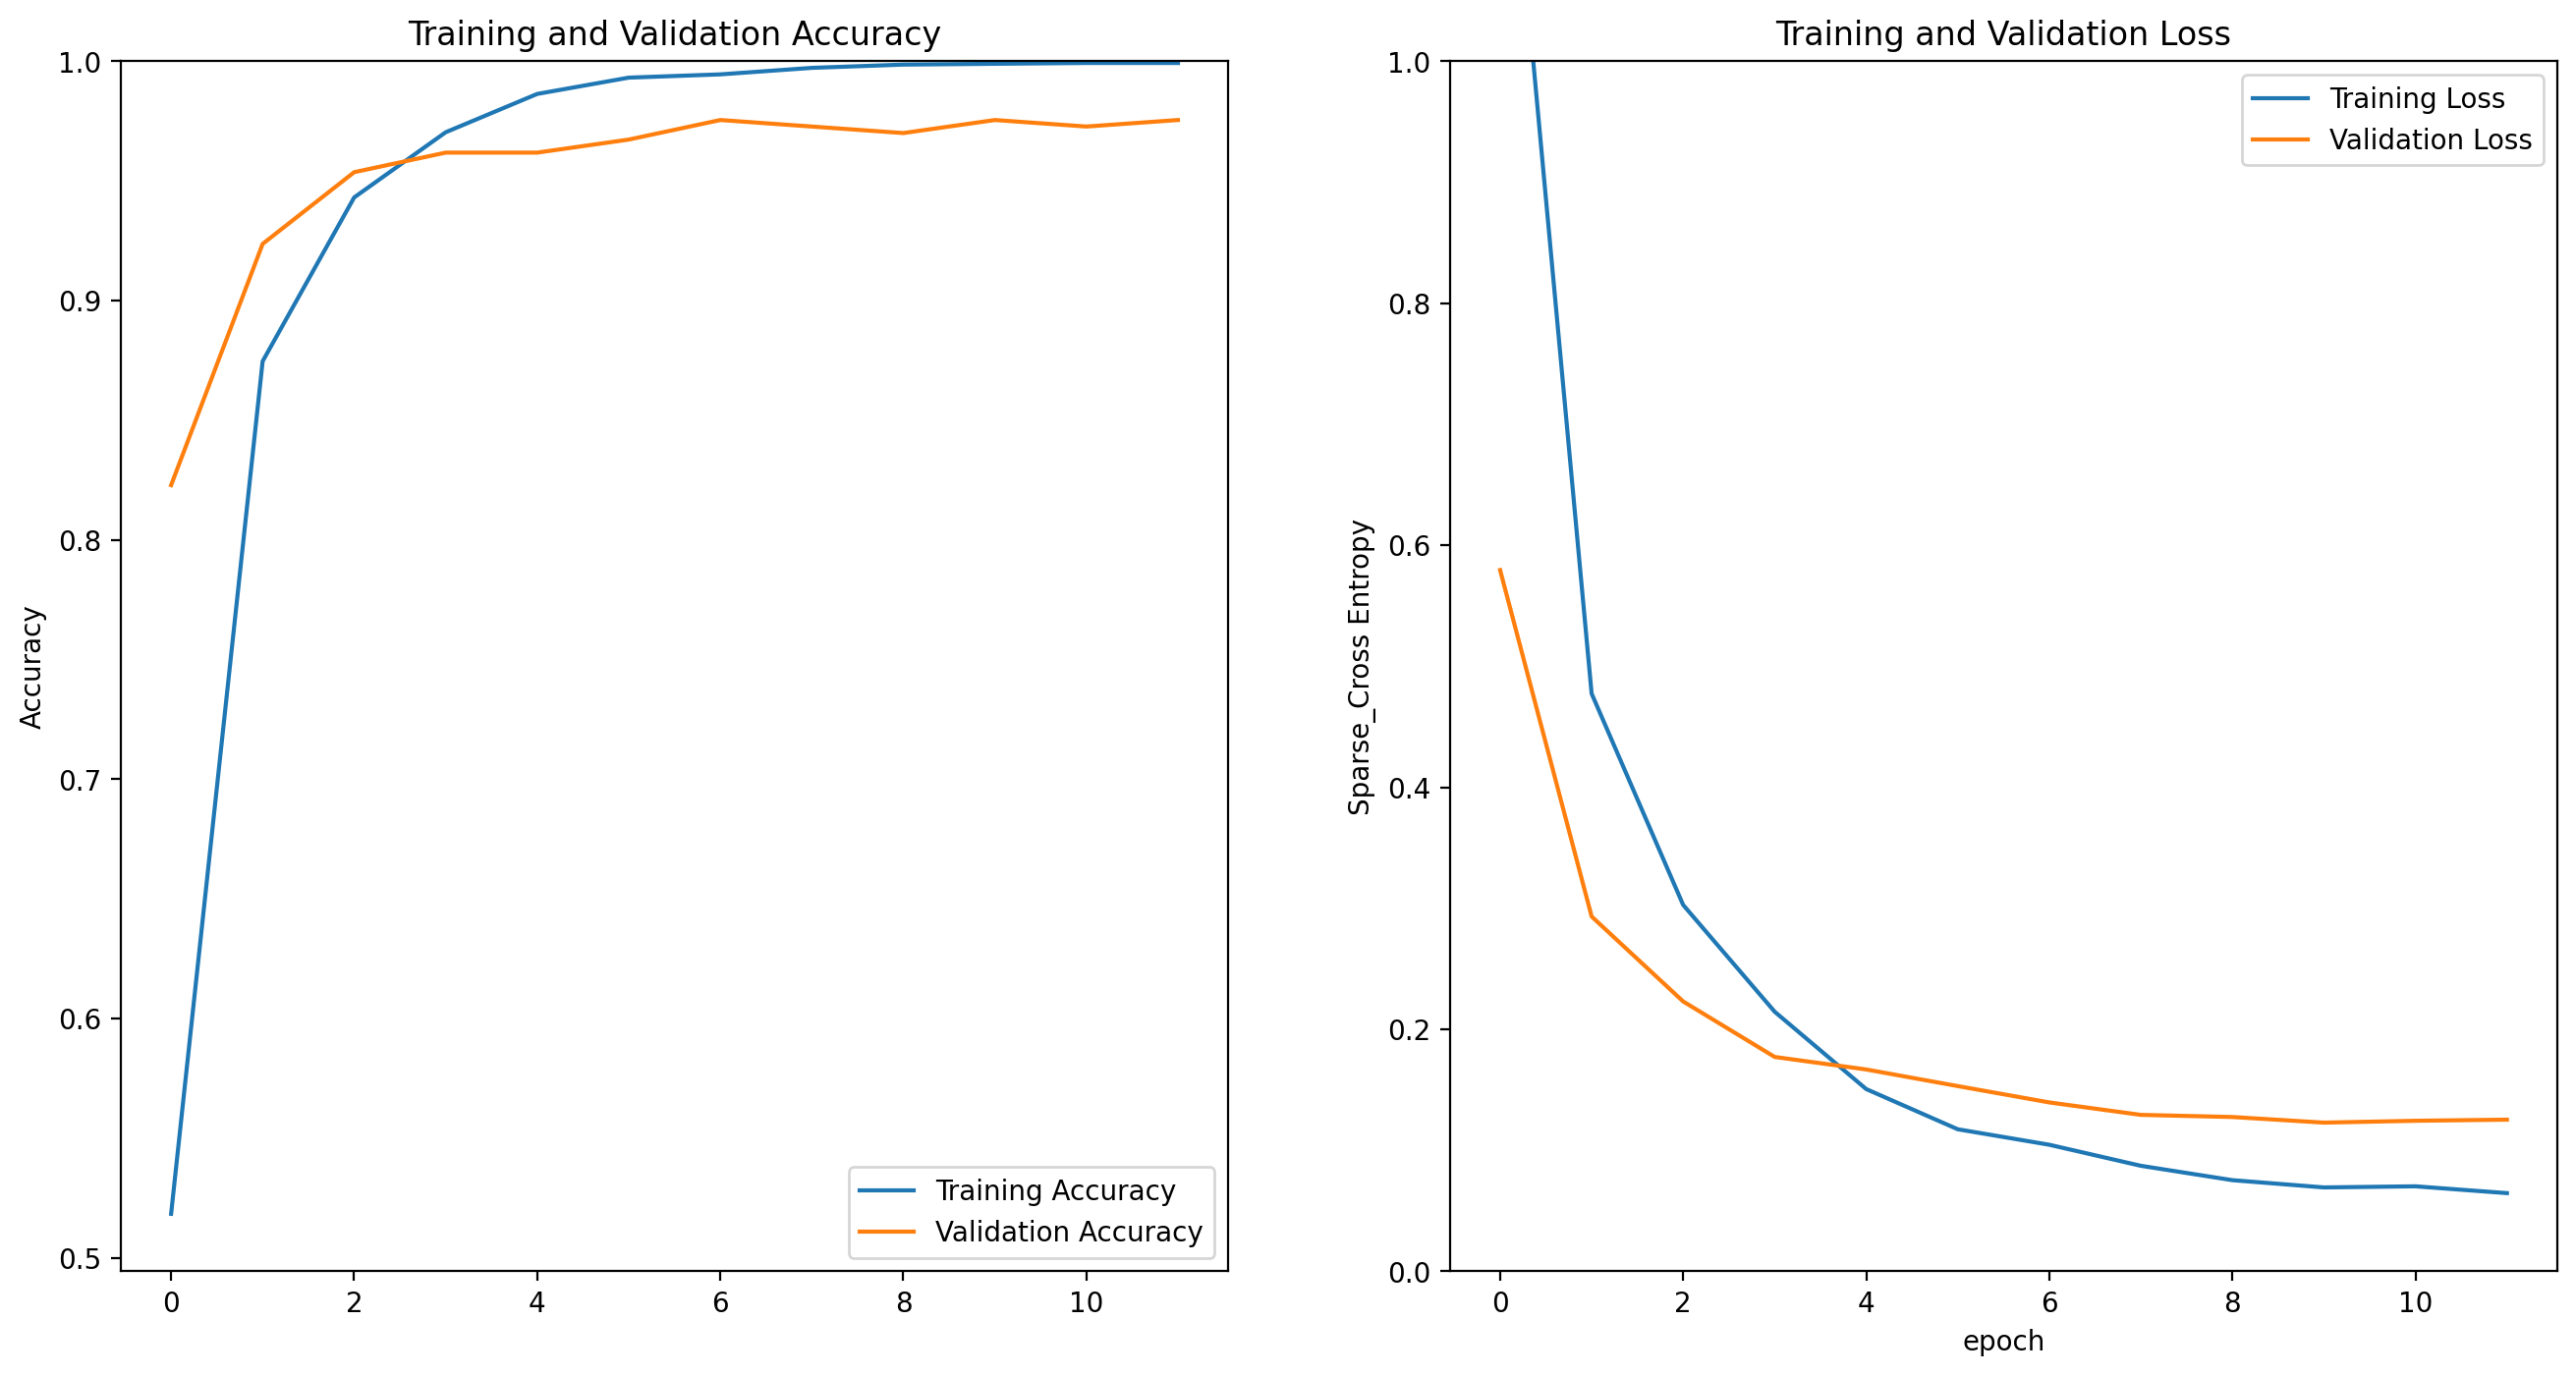

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Sparse_Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
for image_batch, label_batch in test_batches.take(3):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

1/1 [==============================] - 0s 35ms/step


array([[9.72868681e-01, 7.40168802e-03, 6.37747208e-03, 8.94572306e-03,
        4.40652622e-03],
       [1.05999801e-02, 9.63225186e-01, 8.54749524e-04, 3.99108091e-03,
        2.13288851e-02],
       [1.15760211e-02, 5.87285636e-03, 2.88073849e-02, 9.30063665e-01,
        2.36800481e-02],
       [2.40271501e-02, 3.88043514e-03, 9.04828787e-01, 5.32558672e-02,
        1.40078077e-02],
       [9.47181415e-03, 7.58049032e-03, 2.58610398e-02, 9.43362772e-01,
        1.37238828e-02],
       [3.68572064e-02, 1.60677843e-02, 1.76185984e-02, 8.89853239e-01,
        3.96031700e-02],
       [1.19995968e-02, 7.91201182e-03, 9.53821242e-01, 1.50401844e-02,
        1.12270890e-02],
       [1.03388829e-02, 7.51012564e-03, 9.61916447e-01, 6.50045183e-03,
        1.37340408e-02],
       [5.47807571e-03, 4.36415151e-03, 5.52583952e-03, 1.80032998e-02,
        9.66628611e-01],
       [8.00469611e-03, 7.58593902e-03, 9.51812148e-01, 1.30420588e-02,
        1.95550956e-02],
       [9.77607906e-01, 6.9526

In [33]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 1, 3, 2, 3, 3, 2, 2, 4, 2, 0, 3, 1, 2, 4, 0, 4, 4, 1, 4, 0, 3,
       2, 2, 4, 1, 2, 0, 1, 1, 3, 3])

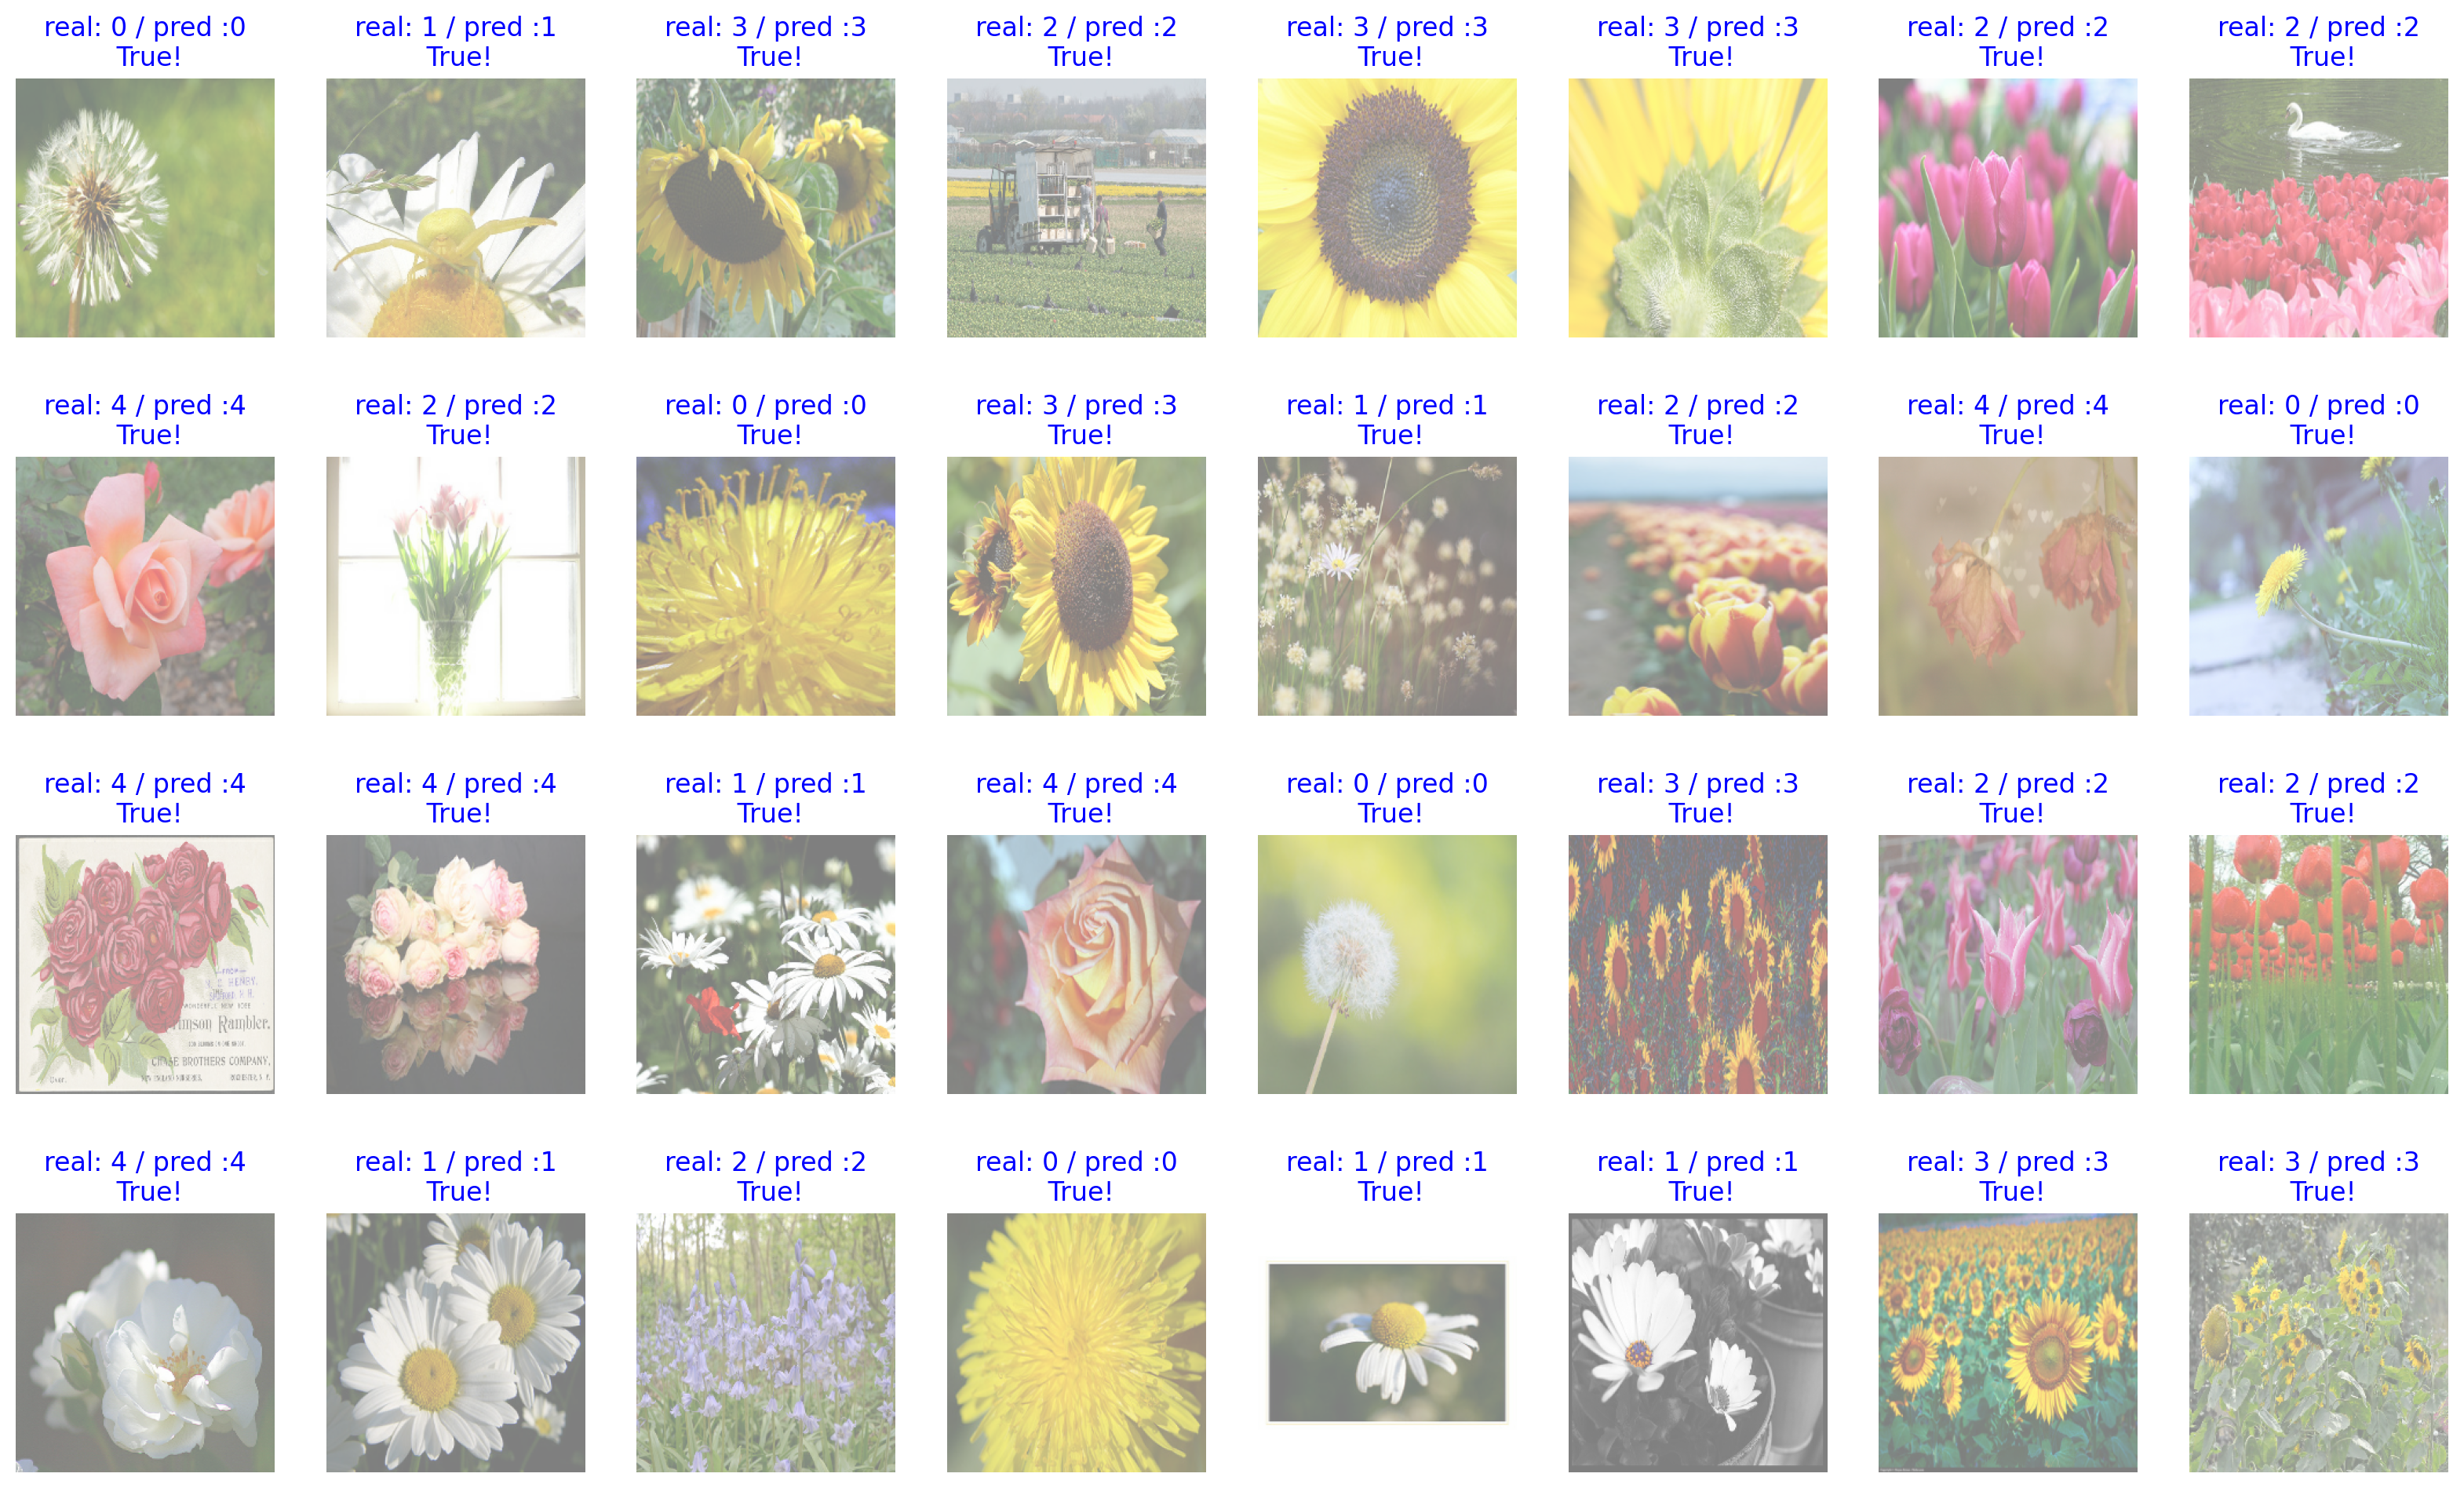

In [34]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [35]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 100% 내외

100.0


In [36]:
import os

checkpoint_dir = "C:\\Users\\james\\tf_flowers\\checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')

model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


In [37]:
# Initialize variables to hold predictions and labels
all_predictions = []
all_labels = []

# Loop over each batch of data
for image_batch, label_batch in test_batches:
    # Make predictions
    predictions = model.predict(image_batch)
    all_predictions.append(predictions)
    all_labels.append(label_batch.numpy())

# Concatenate all the predictions and labels into single arrays
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Convert probabilities to integer labels
predicted_labels = np.argmax(all_predictions, axis=1)

# Your labels are already integers
true_labels = all_labels

# Calculate accuracy
accuracy = np.mean(predicted_labels == true_labels)
print(f'Test accuracy: {accuracy * 100:.2f}%')


1/1 [==============================] - 3s 3s/step
Test accuracy: 97.82%
